In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Mouse USVs
Source:
- Personal correspondance with Gregg Castellucci
- https://mail.google.com/mail/u/0/#search/gregg.castellucci%40nyulangone.org/FFNDWNFQgXNPtvfnjnQhPpPqlhkMJNvb
- Data values
 - Two mice
 - Time is relative to pressure
 - Audio is sampled faster than time
 - audioTime is relative to audio

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython

In [3]:
from avgn.signalprocessing import spectrogramming as sg

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn.visualization.spectrogram import visualize_spec, plot_spec
#from avgn.utils.general import HParams
from avgn.signalprocessing.filtering import butter_bandpass_filter

### data locations

In [6]:
DSLOC = Path('/mnt/cube/Datasets/mouse_usv/FromGregg')

### Parse respiratory files

In [7]:
MATFILE = Path('/mnt/cube/Datasets/mouse_usv/FromGregg/sample_Bl6_breathing_data.mat')

In [8]:
from scipy.io import loadmat

In [21]:
voc_df = loadmat(MATFILE)
voc_df = pd.DataFrame(voc_df['breathing'][0])
voc_df['length_s'] = [np.max(row.time) for idx, row in voc_df.iterrows()]

In [22]:
voc_df

,mouse,genotype,age,time,pressure,audio,audioTime,fs,audioFS,length_s
0,[829],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.062698364, -0.06253052, -0.062194824, -0....","[[0.0017700195], [0.0007324219], [-0.002227783...","[[-0.0017913372, -0.0017873376, -0.001783338, ...",[[10000]],[[250000]],204.633896
1,[832],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.016738892, -0.016723633, -0.016830444, -0...","[[-0.00021362305], [0.0005493164], [0.00045776...","[[-0.0013908836, -0.001386884, -0.0013828843, ...",[[10000]],[[250000]],104.798103
2,[832],[C57Bl/6J],[P76],"[[1e-04, 0.0002, 0.0003, 0.0004, 0.0005, 0.000...","[[-0.01876831, -0.018966675, -0.019165039, -0....","[[0.00024414062], [-0.00012207031], [6.1035156...","[[-0.012664578, -0.012660579, -0.012656579, -0...",[[10000]],[[250000]],141.035095


In [23]:
len(voc_df)

3

In [25]:
len(voc_df)

3

In [34]:
from vocalseg.utils import butter_bandpass_filter, spectrogram, int16tofloat32, plot_spec

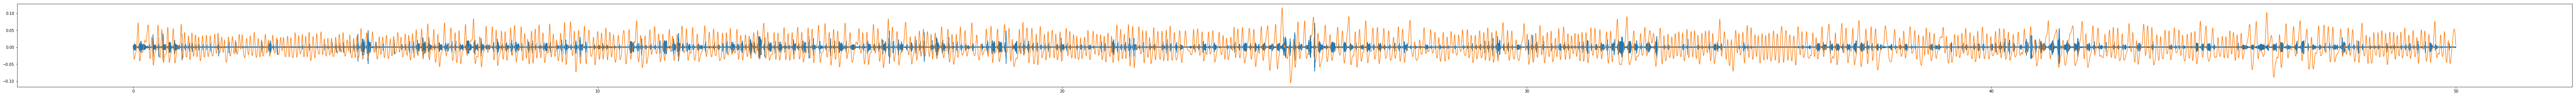

In [43]:
time_samp = [0, 50] # seconds
fig, ax = plt.subplots(figsize=(120,4))

n_samp = 250000
audio_timeframes = (voc_df.audioTime.values[0][0] > time_samp[0]) & (voc_df.audioTime.values[0][0] < time_samp[1])
pressure_timeframes = (voc_df.time.values[0][0] > time_samp[0]) & (voc_df.time.values[0][0] < time_samp[1])
audio = voc_df.audio.values[0][audio_timeframes]
pressure = voc_df.pressure.values[0][0][pressure_timeframes]
pressure = butter_bandpass_filter(pressure, 50, 500, n_samp, order = 2)
ax.plot(np.linspace(time_samp[0], time_samp[1], np.sum(audio_timeframes)), audio)
ax.plot(np.linspace(time_samp[0], time_samp[1], np.sum(pressure_timeframes)), pressure)

In [64]:
### segmentation parameters
n_fft=2048
hop_length_ms=2
win_length_ms=5
ref_level_db=25
pre=0.97
min_level_db=-80
min_level_db_floor = -10
db_delta = 5
silence_threshold = 0.05
min_silence_for_spec=0.01
max_vocal_for_spec=1.0,
min_syllable_length_s = 0.01
butter_min = 50000
butter_max = 100000
spectral_range = [50000, 100000]

In [58]:
from librosa.core.time_frequency import mel_frequencies

In [ ]:
data = audio_timeframes.copy()
rate = n_samp.copy()

In [ ]:
data = butter_bandpass_filter(data, 40000, 120000, rate)

In [65]:
spec = spectrogram(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
)
np.shape(spec)

(1025, 102317)

In [ ]:
np.max(spec)

In [ ]:
fig, ax = plt.subplots(figsize=(100,5))
plot_spec(spec, fig, ax);

In [54]:
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

In [ ]:
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    ref_level_db=ref_level_db,
    pre=pre,
    min_level_db=min_level_db,
    silence_threshold = silence_threshold,
    verbose=True,
    spectral_range = spectral_range,
    min_syllable_length_s = min_syllable_length_s
    
)

In [29]:
rate = 250000

In [30]:
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4096,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-60,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=40000,
    mel_upper_edge_hertz=120000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
    sample_rate=rate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)

# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)

# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(
        tf.constant(
            2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
        ),
        0,
    ),
    tf.float32,
)

mel_matrix = tf.multiply(mel_matrix, enorm)
mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0)).numpy()

2500.0
500.0


NameError: name 'HParams' is not defined

In [134]:
audio = np.squeeze(audio)

In [135]:
#audio = butter_bandpass_filter(audio, lowcut = 4000, highcut=10000, fs=rate, order=4)
spectrogram = sg.spectrogram(audio, hparams)
mel_spec = np.dot(spectrogram.T, mel_matrix).T

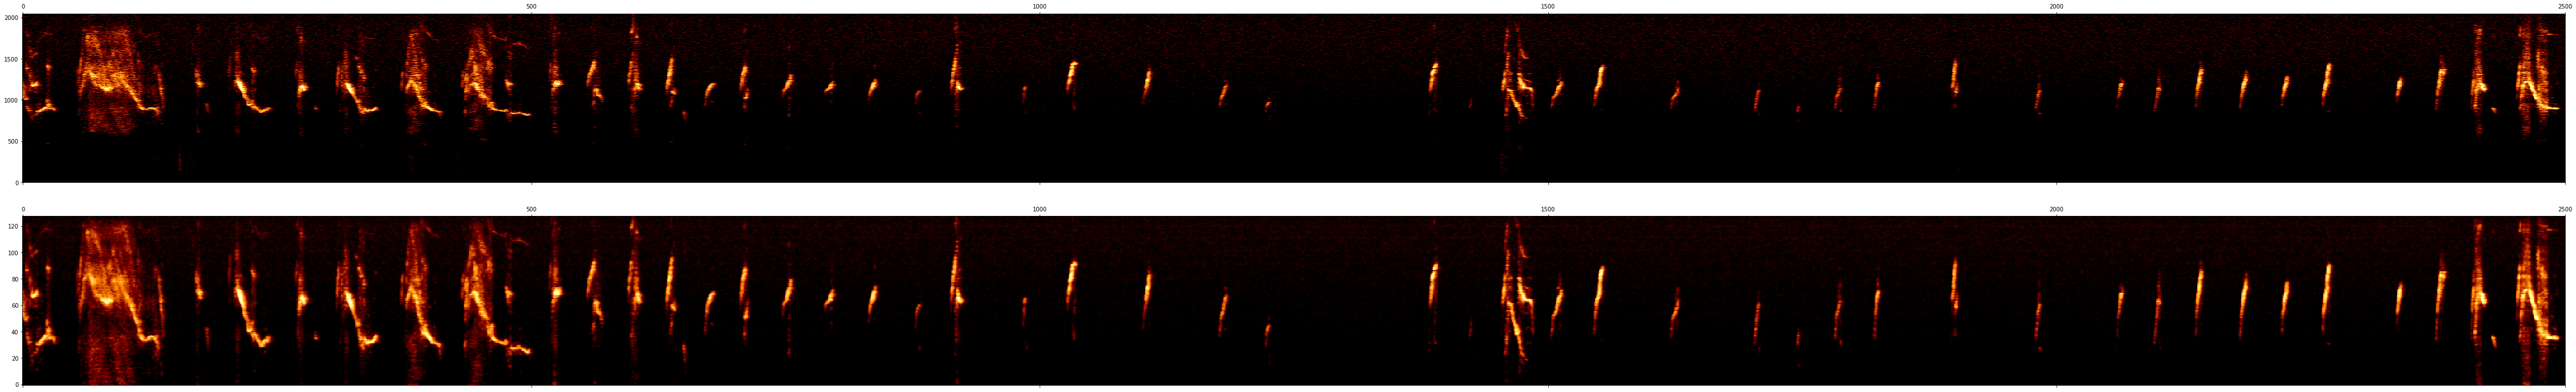

In [136]:
fig, axs = plt.subplots(nrows = 2, figsize=(80,12))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [137]:
from PIL import Image 
def log_resize_spec(spec, spec_len_mul=20, freq_bins = 64):
    resize_shape = [int(np.log(np.shape(spec)[1])*spec_len_mul), freq_bins]
    resize_spec = np.array(Image.fromarray(spec).resize(resize_shape, Image.ANTIALIAS))
    return resize_spec

def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length
    """
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

def make_spec(data, hparams):
    spectrogram = sg.spectrogram(data, hparams)
    #spectrogram = mask_spec(spectrogram)
    spectrogram = spectrogram/np.max(spectrogram)
    #return spectrogram
    mel_spec = np.dot(spectrogram.T, mel_matrix).T
    mel_spec = mask_spec(mel_spec)
    return mel_spec

def mask_spec(spec, spec_thresh=.5, offset=1e-10):
    mask = spec >= (spec.max(axis=0,keepdims=1)*spec_thresh+offset)
    #plt.matshow(mask)
    return spec*mask

In [138]:
spectrogram = make_spec(audio, hparams)

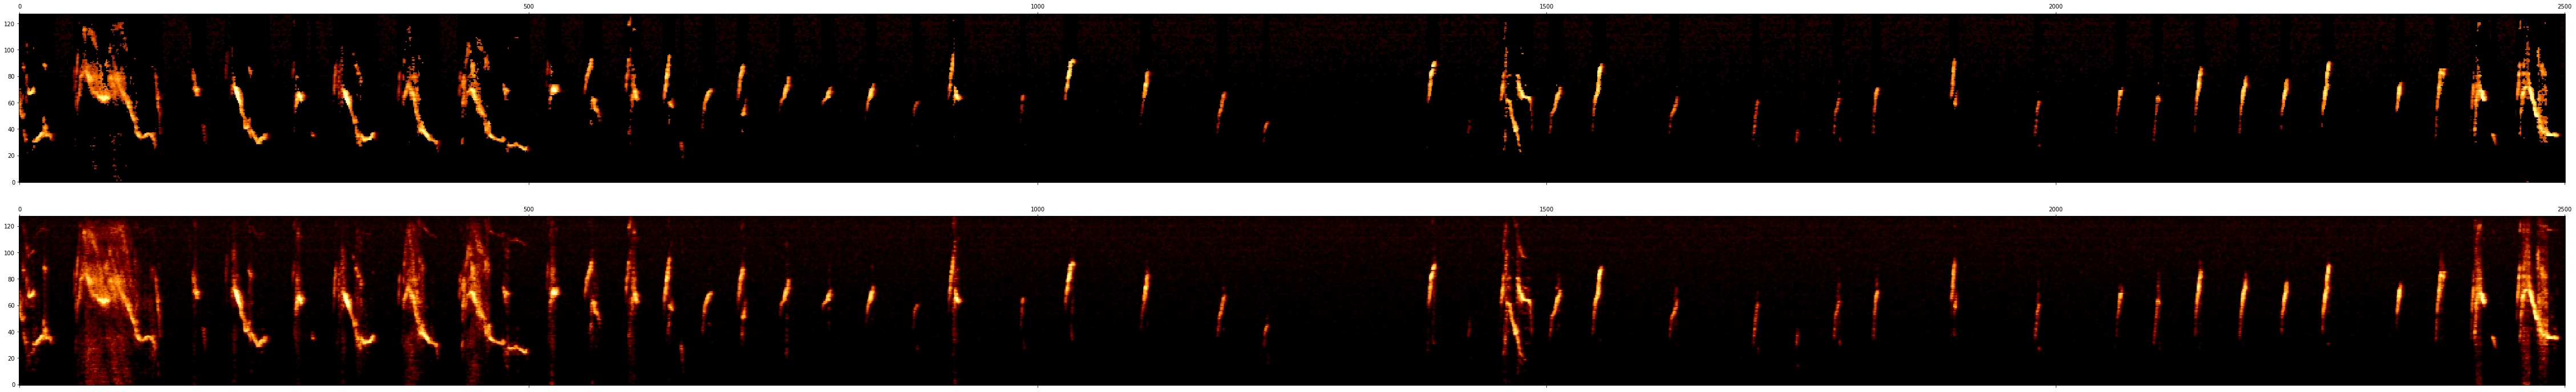

In [139]:
fig, axs = plt.subplots(nrows = 2, figsize=(80,12))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')